# Taxi Demand Prediction - Support Vector Machine
---
In this notebook, we build a model for predicting taxi demand in Chicago. The model is based on the information provided by the city of Chicago in 2015.

Furthermore, the model is based on all of the available data. Since the prediction target is taxi demand which is calculated by data aggregation, we won't encounter any memory problems.

To build our demand prediction model, we proceed as following:

In [1]:
cd ..

/Users/simonwolf/git/aaa21


In [2]:
import utils, feature_engineering, geo_engineering, preprocessing, prediction_utils, prediction_svm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Daily Models
---
Explanations...

## Data Preparation
---

In [3]:
# Takes few minutes to run (16 GB RAM)
chicago_df = utils.read_parquet('Taxi_Trips_Cleaned.parquet',
                                columns=['Trip ID','Trip Start Timestamp','Pickup Community Area',
                                         'Dropoff Community Area'])
weather_df = utils.read_parquet('Weather.parquet',columns = ['Trip Start Timestamp','Humidity(%)',
                                    'Pressure(hPa)','Temperature(C)',
                                    'Wind Direction(Meteoro. Degree)','Wind Speed(M/S)'])

daily_demand = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='D')
#daily_demand_hex_7 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='D',
#                                            use_hexes=True,hex_resolution=7)
#daily_demand_hex_6 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='D',
#                                            use_hexes=True,hex_resolution=6)

del chicago_df
del weather_df

### Feature Engineering
---
In this section we add the following spatial and temporal features to our data before prediction.
- Distance to Chicago City Center
- Distance to Chicago Airport
- Holiday Events

In [4]:
#Spatial Features
daily_demand = feature_engineering.add_spatial_features(daily_demand)
#daily_demand_hex_7 = feature_engineering.add_spatial_features(daily_demand_hex_7,with_hex=7,hex_res=7)
#daily_demand_hex_6 = feature_engineering.add_spatial_features(daily_demand_hex_6,with_hex=6,hex_res=6)
#Holidays
daily_demand = feature_engineering.add_holidays(daily_demand)
#daily_demand_hex_6 = feature_engineering.add_holidays(daily_demand_hex_6)
#daily_demand_hex_7 = feature_engineering.add_holidays(daily_demand_hex_7)

### Daily Model - Community Areas
---
In this section we build our nn model for demand prediction using community areas as our geographical attributes. we build different models and opt for the final model by comparing the overall evaluation metrics.

### Model Architecture
---
To gain a better understanding of our data and the amount of complexity needed in the nn architecture we first start our daily model by a simple 50 * 25 structure. After observing the behavoiur of the model we adjust the layer structure. First by adding/removing nodes , Second by increasing/decreasing the number of hidden layers of the network. For the sake of brevity this notebook does not show all tested nn architectures.

_Note: This was an iterative process. We didn't use brut force algorithms to search for the optimal structure on a grid as it is not computationaly feasible._

### Suitable Metrics
---
To gain a better understanding which metrics we should apply to our problem we plot the prediction target to identify the distribution type.

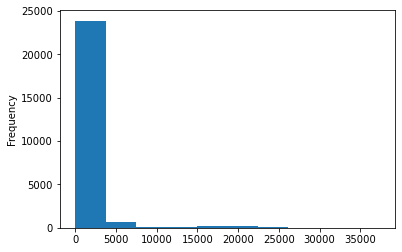

In [5]:
daily_demand['Demand (D)'].plot.hist()
plt.show()

As we expected the target is extremely skewed. Which would make the prediction metrics non telling. To tackle this obstacle, we transform the target logarithmically. And use the mean squared logarithmic error as our metric.

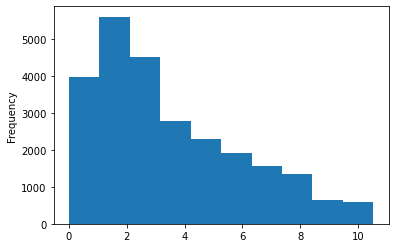

In [6]:
daily_demand['Demand (D)'] = np.log(daily_demand['Demand (D)'])
daily_demand['Demand (D)'].plot.hist()
plt.show()

In [7]:
#Train - Validation - Test Split
train_data, val_data, test_data = prediction_svm.split_data_sets_for_svm(daily_demand, temporal_resolution='D',
                                                               test_size=0.2, validation_size=0.2)

In [8]:
#Augmented data
train_data.head(5)

,Demand (D),Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,Elapsed,0,...,536,537,538,539,540,541,542,543,544,545
0,6.006353,100.0,1034.250777,-5.435774,249.09522,9.069681,14.731612,9653.373658,1420070400,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.465736,100.0,1034.250777,-5.435774,249.09522,9.069681,18.830572,9653.213140,1420070400,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.290459,100.0,1034.250777,-5.435774,249.09522,9.069681,16.315833,9653.268017,1420070400,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.708050,100.0,1034.250777,-5.435774,249.09522,9.069681,16.744923,9653.266876,1420070400,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.663562,100.0,1034.250777,-5.435774,249.09522,9.069681,14.040299,9653.330387,1420070400,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(train_data.select_dtypes(include="number").columns)
print('\nCategorical variables:')
print(train_data.select_dtypes(include="category").columns)

Continuous variables:
Index(['Demand (D)', 'Humidity(%)', 'Pressure(hPa)', 'Temperature(C)',
       'Wind Direction(Meteoro. Degree)', 'Wind Speed(M/S)',
       'City Center Distance', 'Airport Distance', 'Elapsed'],
      dtype='object')

Categorical variables:
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       536, 537, 538, 539, 540, 541, 542, 543, 544, 545],
      dtype='object', length=546)


In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train = train_data.drop(columns="Demand (D)")
X_test = test_data.drop(columns="Demand (D)")
y_train = train_data["Demand (D)"]
y_test = test_data["Demand (D)"]

regr = make_pipeline(StandardScaler(), SVR()) # Optimize Parameters
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(y_test), y_predicted=np.exp(y_pred), s_mape=True)

# ----

In [6]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.svm import SVR
from tqdm import tqdm_notebook

tscv = TimeSeriesSplit(n_splits=5)
scores = []
for tr_index, val_index in tqdm_notebook(tscv.split(X_train)):
    print("TRAIN:", tr_index, "VALIDATION:", val_index)
    X_tr, X_val = X_train.loc[tr_index], X_train.loc[val_index]
    y_tr, y_val = y_train.loc[tr_index], y_train.loc[val_index]
        
    parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[1, 10, 100, 1000], 'degree':[1, 2, 3, 4, 5], 'epsilon':[0.1, 0.2, 0.3]}
    svr = SVR()
    clf = GridSearchCV(svr, parameters)
    clf.fit(X_tr, y_tr)

0it [00:00, ?it/s]

TRAIN: [   0    1    2 ... 3363 3364 3365] VALIDATION: [3366 3367 3368 ... 6729 6730 6731]
TRAIN: [   0    1    2 ... 6729 6730 6731] VALIDATION: [ 6732  6733  6734 ... 10095 10096 10097]
TRAIN: [    0     1     2 ... 10095 10096 10097] VALIDATION: [10098 10099 10100 ... 13461 13462 13463]
TRAIN: [    0     1     2 ... 13461 13462 13463] VALIDATION: [13464 13465 13466 ... 16827 16828 16829]
TRAIN: [    0     1     2 ... 16827 16828 16829] VALIDATION: [16830 16831 16832 ... 20193 20194 20195]


In [18]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,30.099232,3.150788,0.915923,0.013788,1,linear,"{'C': 1, 'kernel': 'linear'}",-0.067180,-0.066855,-0.066889,-0.067056,-0.062898,-0.066176,0.001643,3
1,8.443325,0.100911,4.071352,0.107611,1,rbf,"{'C': 1, 'kernel': 'rbf'}",-0.076213,-0.074807,-0.074842,-0.075839,-0.072159,-0.074772,0.001418,6
2,41.320247,2.700932,0.927999,0.007206,10,linear,"{'C': 10, 'kernel': 'linear'}",-0.041410,-0.030557,-0.035402,-0.039948,-0.034882,-0.036440,0.003876,2
3,8.258576,0.029741,4.054072,0.048625,10,rbf,"{'C': 10, 'kernel': 'rbf'}",-0.072812,-0.071688,-0.071718,-0.072721,-0.068688,-0.071525,0.001497,5
4,45.951010,7.583730,0.936804,0.023408,100,linear,"{'C': 100, 'kernel': 'linear'}",-0.003912,-0.045508,0.030224,0.017465,0.013902,0.002434,0.026338,1
5,8.702239,0.074813,4.210126,0.063865,100,rbf,"{'C': 100, 'kernel': 'rbf'}",-0.069865,-0.069127,-0.069297,-0.070177,-0.065951,-0.068883,0.001514,4


In [7]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_epsilon,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,32.810551,3.725767,0.969801,0.004394,1,1,0.1,linear,"{'C': 1, 'degree': 1, 'epsilon': 0.1, 'kernel'...",-0.067180,-0.066855,-0.066889,-0.067056,-0.062898,-0.066176,0.001643,52
1,7.031046,0.067358,1.069073,0.006496,1,1,0.1,poly,"{'C': 1, 'degree': 1, 'epsilon': 0.1, 'kernel'...",-0.076761,-0.075230,-0.075261,-0.076266,-0.072579,-0.075220,0.001445,203
2,9.064715,0.058918,4.226599,0.028530,1,1,0.1,rbf,"{'C': 1, 'degree': 1, 'epsilon': 0.1, 'kernel'...",-0.076213,-0.074807,-0.074842,-0.075839,-0.072159,-0.074772,0.001418,188
3,8.721885,0.084872,1.598513,0.009816,1,1,0.1,sigmoid,"{'C': 1, 'degree': 1, 'epsilon': 0.1, 'kernel'...",-0.077122,-0.075583,-0.075556,-0.076570,-0.072913,-0.075549,0.001447,206
4,32.441598,3.465476,0.988467,0.032004,1,1,0.2,linear,"{'C': 1, 'degree': 1, 'epsilon': 0.2, 'kernel'...",-0.067319,-0.066827,-0.066817,-0.067033,-0.062926,-0.066184,0.001639,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,8.481896,0.145196,1.632038,0.012540,1000,5,0.2,sigmoid,"{'C': 1000, 'degree': 5, 'epsilon': 0.2, 'kern...",-0.063445,-0.082911,-0.081402,-0.046172,-0.019421,-0.058670,0.023765,36
236,48.816217,3.657469,0.996736,0.024997,1000,5,0.3,linear,"{'C': 1000, 'degree': 5, 'epsilon': 0.3, 'kern...",-21.053274,-7.087611,-8.352603,-4.788528,-0.825049,-8.421413,6.815428,226
237,7.977365,0.075513,1.135174,0.008341,1000,5,0.3,poly,"{'C': 1000, 'degree': 5, 'epsilon': 0.3, 'kern...",-0.063800,-0.063874,-0.064328,-0.066052,-0.061580,-0.063927,0.001428,43
238,9.162754,0.089796,4.272238,0.047604,1000,5,0.3,rbf,"{'C': 1000, 'degree': 5, 'epsilon': 0.3, 'kern...",-0.068344,-0.068010,-0.068099,-0.069067,-0.064273,-0.067558,0.001684,65


In [10]:
results = pd.DataFrame(clf.cv_results_)
results[results["rank_test_score"]<10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_epsilon,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
60,45.558073,3.017582,0.980534,0.002894,10,1,0.1,linear,"{'C': 10, 'degree': 1, 'epsilon': 0.1, 'kernel...",-0.041410,-0.030557,-0.035402,-0.039948,-0.034882,-0.036440,0.003876,6
72,45.636294,3.268307,0.981767,0.016091,10,2,0.1,linear,"{'C': 10, 'degree': 2, 'epsilon': 0.1, 'kernel...",-0.041410,-0.030557,-0.035402,-0.039948,-0.034882,-0.036440,0.003876,6
84,45.643183,3.080409,0.998659,0.024704,10,3,0.1,linear,"{'C': 10, 'degree': 3, 'epsilon': 0.1, 'kernel...",-0.041410,-0.030557,-0.035402,-0.039948,-0.034882,-0.036440,0.003876,6
96,45.624369,3.061219,0.984654,0.012247,10,4,0.1,linear,"{'C': 10, 'degree': 4, 'epsilon': 0.1, 'kernel...",-0.041410,-0.030557,-0.035402,-0.039948,-0.034882,-0.036440,0.003876,6
108,45.608045,2.953863,0.979030,0.009657,10,5,0.1,linear,"{'C': 10, 'degree': 5, 'epsilon': 0.1, 'kernel...",-0.041410,-0.030557,-0.035402,-0.039948,-0.034882,-0.036440,0.003876,6
120,48.965204,8.376713,0.977310,0.006093,100,1,0.1,linear,"{'C': 100, 'degree': 1, 'epsilon': 0.1, 'kerne...",-0.003912,-0.045508,0.030224,0.017465,0.013902,0.002434,0.026338,1
132,48.957661,8.424069,0.994559,0.019789,100,2,0.1,linear,"{'C': 100, 'degree': 2, 'epsilon': 0.1, 'kerne...",-0.003912,-0.045508,0.030224,0.017465,0.013902,0.002434,0.026338,1
144,49.076250,8.391970,0.991273,0.019573,100,3,0.1,linear,"{'C': 100, 'degree': 3, 'epsilon': 0.1, 'kerne...",-0.003912,-0.045508,0.030224,0.017465,0.013902,0.002434,0.026338,1
156,49.106059,8.364369,0.986654,0.007266,100,4,0.1,linear,"{'C': 100, 'degree': 4, 'epsilon': 0.1, 'kerne...",-0.003912,-0.045508,0.030224,0.017465,0.013902,0.002434,0.026338,1
168,48.988906,8.388970,0.985561,0.005986,100,5,0.1,linear,"{'C': 100, 'degree': 5, 'epsilon': 0.1, 'kerne...",-0.003912,-0.045508,0.030224,0.017465,0.013902,0.002434,0.026338,1
